# **Model Training**

<div align='center'>

A dedicated notebook for all of our modeling code. This include preprocessing, training, tuning, diagnosing errors, and evaluating factors for our model.

</div>

## Overview

This project implements a structural risk model to estimate the expected Readiness Gap (Graduation Rate − College and Career Readiness) at the school level. The model examines how contextual and climate factors are associated with the likelihood that students graduate without meeting readiness benchmarks.

<br>

The tuned Beta Regression model includes the following features:

- Economic Need Index (ENI)

- Log-transformed percent of students in temporary housing

- Teaching Environment (% positive survey responses)

- ENI × Teaching Environment interaction term

- Average student attendance

- Student Support (% positive survey responses)

- Borough indicators (Brooklyn, Manhattan, Queens, Staten Island; Bronx as reference)

<br>

By estimating the expected Readiness Gap given these structural, climate, and geographic factors, our model provides a benchmark against which observed outcomes can be compared.

Our goal is not to predict individual student outcomes, but to identify school-level risk patterns and highlight where outcomes diverge from structural expectations. We hope this can enable stakeholders to move from descriptive reporting toward targeted, equity-focused resource allocation and intervention planning.

### **Critical Research Question (CRQ)**
To what extent do a high school’s Economic Need Index (ENI) and Percent of Students in Temporary Housing predict the Readiness-Gap (percentage difference between high school graduation & College and Career Readiness) for specific demographic subgroups, and which schools serve as "positive outliers" by defying these systemic predictors?

In [157]:
# Basic Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Processing + Diagnostics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [158]:
# connecting to db to query it

path = '/Users/Marcy_Student/Desktop/Marcy-Modules/CID/CID_data-slayer-corps/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [159]:
query = """
SELECT borough,
e.school_name,
metric_value_postsecondary_enrollment_6_months AS postsec_enroll_6mo, 
economic_need_index AS eni_rate,
percent_temp_housing AS pct_temp_housing,
metric_value_4yr_ccr_all_students AS ccr_rate,
family_involvement_pct_positive, 
avg_student_attendance
FROM dim_location l
JOIN dim_environment e
ON e.DBN = l.DBN
JOIN fact_school_outcomes f
ON e.DBN = f.DBN
"""

df = pd.read_sql_query(query, conn)
df

,borough,school_name,postsec_enroll_6mo,eni_rate,pct_temp_housing,ccr_rate,family_involvement_pct_positive,avg_student_attendance
0,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
1,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
2,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
3,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0,0.81,0.818
4,Manhattan,University Neighborhood High School,0.839,0.719,0.097,77.1,0.82,0.915
...,...,...,...,...,...,...,...,...
2019,Bronx,Bronx Preparatory Charter School,0.722,0.912,0.097,NaN,NaN,0.847
2020,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934
2021,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934
2022,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN,NaN,0.934


## **Step 1: Preprocessing**

- **Missing values**
    - Simply dropping values, ensuring most/all schools contribute to model.

- **Outliers/Distribution**
    - Observing outliers, transforming data based on distributions.

- **Creating Binary Column**
    - For Logistic Model, low CCR and high CCR based on the 75th quartile.

***

### **Missing Values**

We are simply dropping all missing values from these columns. After inspection, there is still a sufficient number of rows to model with.

In [160]:
# missing values
display(df.isna().sum())

# ccr_rate, eni_rate have NAs. We will drop them (among others).

df1 = df[['ccr_rate', 'eni_rate', 'pct_temp_housing', 'avg_student_attendance']].dropna()
display(df1.isna().sum())
display(df1.shape)

borough                              0
school_name                          0
postsec_enroll_6mo                 128
eni_rate                           268
pct_temp_housing                     0
ccr_rate                           364
family_involvement_pct_positive    216
avg_student_attendance              44
dtype: int64

ccr_rate                  0
eni_rate                  0
pct_temp_housing          0
avg_student_attendance    0
dtype: int64

(1408, 4)

***

### **Sanity Check: Scatterplots**

Creating a scatter plot of our features against our target variable. Getting an idea of any relationships our data has prior to modeling.

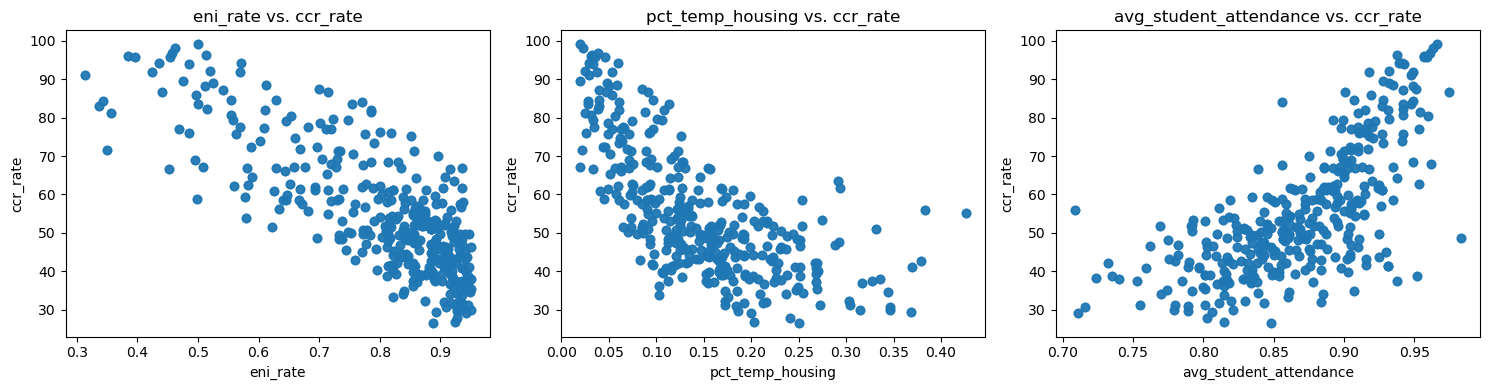

In [161]:
# streamlined multiple scatterplots all in one figure

features = ['eni_rate', 'pct_temp_housing', 'avg_student_attendance']
plt.figure(figsize=(15, 4))

for f in features:
    plt.subplot(1, 3, features.index(f) + 1)
    plt.scatter(df1[f], df1['ccr_rate'], alpha=0.5)
    plt.xlabel(f)
    plt.ylabel('ccr_rate')
    plt.title(f'{f} vs. ccr_rate')

plt.tight_layout()
plt.show()

***

### **Outliers**

Defining a function to get a summary of outliers. This includes # of outlier values, percentage of outliers from entire column length, and the bounds upper/lower bounds, representing our threshold of what constitutes outliers.

In [162]:
# defining a function to identify outliers using IQR
def outliers(dataframe, columns):
    summary = {}
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outlier_df = dataframe[(dataframe[col] < lower) | (dataframe[col] > upper)]

        summary[col] = {
            'count': len(outlier_df),
            'pct': (len(outlier_df) / len(dataframe)) * 100,
            'lower_bound': lower,
            'upper_bound': upper,
            'min': dataframe[col].min(),
            'max': dataframe[col].max()
        }
    return summary

# real quick: need to make ccr_rate between 0 and 1
df1['ccr_rate'] = df1['ccr_rate'] / 100

# apply to df1 columns
outlier_results = outliers(df1, df1.columns)

# displaying outliers for all columns
for col, stats in outlier_results.items():
    print(f"{col}:")
    print(f"  Outliers: {stats['count']} ({stats['pct']:.2f}%)")
    print(f"  Bounds: [{stats['lower_bound']:.4f}, {stats['upper_bound']:.4f}]")
    print(f"  Min: {stats['min']:.4f}, Max: {stats['max']:.4f}\n")

ccr_rate:
  Outliers: 20 (1.42%)
  Bounds: [0.1159, 0.9589]
  Min: 0.2660, Max: 0.9910

eni_rate:
  Outliers: 60 (4.26%)
  Bounds: [0.4702, 1.1643]
  Min: 0.3140, Max: 0.9500

pct_temp_housing:
  Outliers: 28 (1.99%)
  Bounds: [-0.0644, 0.3446]
  Min: 0.0200, Max: 0.4260

avg_student_attendance:
  Outliers: 16 (1.14%)
  Bounds: [0.7249, 1.0179]
  Min: 0.7090, Max: 0.9830



### **Outlier Summary**
Nothing looks crazy enough here to take action. I will move on.

<br>

***

### **Distribution**

Here, we want to look at the distributions of our data before inputting into our model. Skewness can affect outputs, as well as extreme values. Transformations must be done for better, more interpretable results.

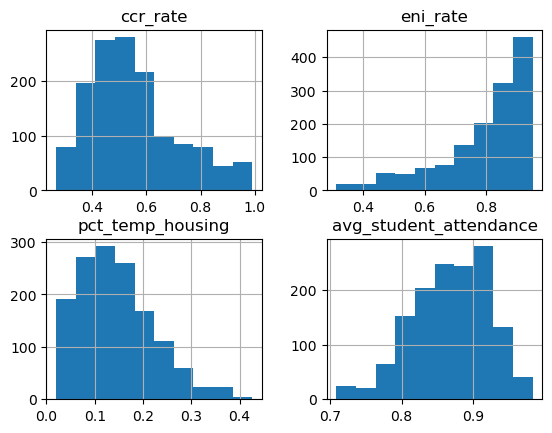

In [163]:
# distribution
df1.hist() 

# we'll likely need to make eni more normal.
# let's use logit eni_rate, since it's heavily left-skewed

# logit eni_rate
# Using a small epsilon (0.001) to avoid division by zero
epsilon = 0.001
df1['logit_eni'] = np.log((df1['eni_rate'] + epsilon) / (1 - df1['eni_rate'] + epsilon))


# for the rest, we'll simply square root (since they're not terribly skewed)
for col in ['ccr_rate', 'pct_temp_housing', 'avg_student_attendance']:
    df1[f'sqrt_{col}'] = np.sqrt(df1[col])


array([[<Axes: title={'center': 'sqrt_ccr_rate'}>,
        <Axes: title={'center': 'logit_eni'}>],
       [<Axes: title={'center': 'sqrt_pct_temp_housing'}>,
        <Axes: title={'center': 'sqrt_avg_student_attendance'}>]],
      dtype=object)

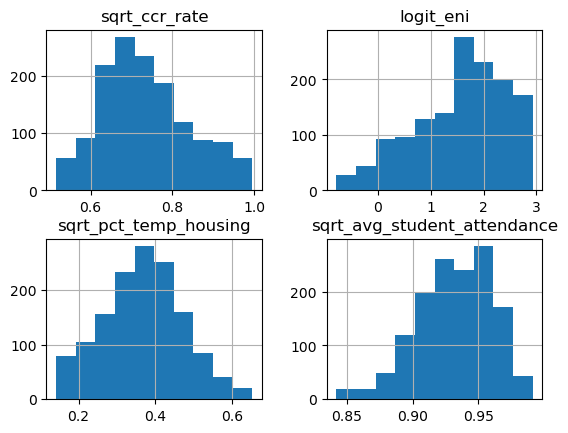

In [173]:
# Let's check our transformed distributions
df1[['sqrt_ccr_rate', 'logit_eni', 'sqrt_pct_temp_housing', 'sqrt_avg_student_attendance']].hist()

### **Distribution Summary**

Distributions look much better. This will provide better model stability for our simpler models.

<br>

> **Important to Note:**
> This changes coefficient interpretation. +1 unit increase increases by sqrt/logit.

<br>

***

<br>

### **Final Preprocessing Step: Binary Target Variable (y)**

In [165]:
# Creating Binary
df1['is_high_ccr'] = (df1['ccr_rate'] >= (np.quantile(df1['ccr_rate'], 0.75))).astype(int)
df1['is_high_ccr'].value_counts()

0    1056
1     352
Name: is_high_ccr, dtype: int64

***

## **Step 2: Modeling**

### **Train-Test Split, Constant, and Inputting to Model**

> !NOTE
> This linear model is purely for EDA, to give insight into the magnitude + direction of our variables, as well as observe its alignment with our CRQ and hypothesis.

### **Linear Regression (OLS)**

Using multiple variables to test variance of factors.

In [166]:
# Our variables
X1 = df1[['logit_eni', 'sqrt_avg_student_attendance']]
y1 = df1['sqrt_ccr_rate']

# Split dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Add constant
X1_train = sm.add_constant(X1_train) 
X1_test = sm.add_constant(X1_test)

In [167]:
# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

print(vif_data)

                       feature      VIF
0                    logit_eni  3.99685
1  sqrt_avg_student_attendance  3.99685


### **VIF Summary**

VIF scores look good, there is not heavy multicollinearity at all.

In [168]:
# Train the model
model1 = sm.OLS(y1_train, X1_train)
results = model1.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sqrt_ccr_rate   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     1096.
Date:                Fri, 20 Feb 2026   Prob (F-statistic):          1.13e-264
Time:                        16:28:12   Log-Likelihood:                 1518.7
No. Observations:                1126   AIC:                            -3031.
Df Residuals:                    1123   BIC:                            -3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.3216      0.083     -3.878      0.000      -0.484      -0.159
logit_eni                      -0.0700      0.003    -24.386      0.000      -0.076      -0.064
sqrt_avg_student_attendance     1.2510      0.086     14.573      0.000       1.083       1.419
==============================================================================
Omnibus:                        1.890   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.902
Skew:                          -0.100   Prob(JB):                        0.386
Kurtosis:                       2.973   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

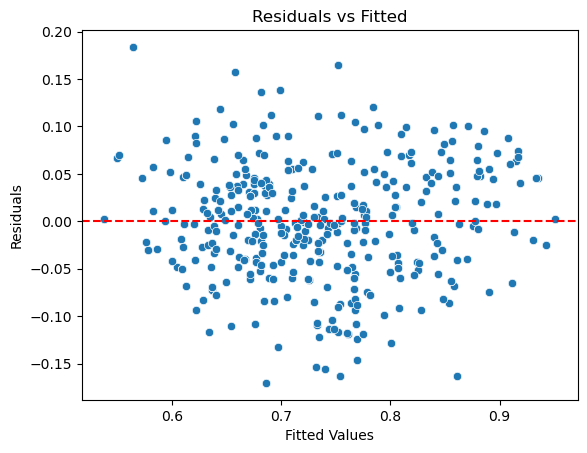

In [169]:
# Looking at Residuals
residuals = results.resid
fitted = results.fittedvalues

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

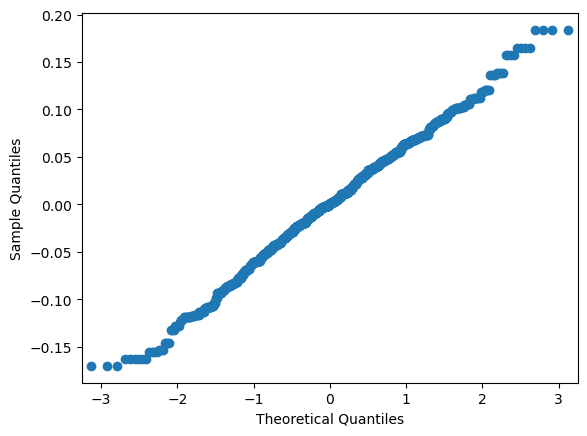

In [170]:
# Q-Q Plot
sm.qqplot(residuals)
plt.show()

<br>

***

<br>

### **Logistic Model**

<br>

#### **Baseline Model: Dummy Classifier**

For our baseline model, we are going to be using Dummy Classifier. This is a model that makes predictions without using any input features and performs no learning. Essentially, it serves as a target reference that our subsequent models should outperform.


Our Dummy Classifier Model in particular will always predict the majority class of our target variable (y), which in this case is low College & Career Readiness (CCR). This should amount to a ~75% accuracy, given our sample split.

In [174]:
# Baseline DummyClassifier using only logit_eni
X_dummy = df1[['logit_eni']]
y_dummy = df1['is_high_ccr']

X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=42)

dummy = DummyClassifier(strategy='most_frequent')  # always predict majority class
dummy.fit(X_dummy_train, y_dummy_train)
y_dummy_pred = dummy.predict(X_dummy_test)

print("Accuracy:", accuracy_score(y_dummy_test, y_dummy_pred))
print("Classification Report:\n", classification_report(y_dummy_test, y_dummy_pred, target_names=['Low/Med CCR (0)', 'High CCR (1)']))

Accuracy: 0.7659574468085106
Classification Report:
                  precision    recall  f1-score   support

Low/Med CCR (0)       0.77      1.00      0.87       216
   High CCR (1)       0.00      0.00      0.00        66

       accuracy                           0.77       282
      macro avg       0.38      0.50      0.43       282
   weighted avg       0.59      0.77      0.66       282



/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

#### **Simple Model: Logistic Classification Model**

For our simple logistic model, the binary y will represent high ccr past the 75th percentile. We will be using `class_weight={0:1, 1:0.8}`. Broken down, this is telling us that Low/Med CCR mistakes weigh as a complete 1, whereas High CCR mistakes weigh only 0.8. This is important because we believe falsely labeling a school High CCR is more costly.

<br>

> **Important to Note:**
> using this parameter does not remove data, create synthetic data, or up/down samples the classes. It still keeps all the data, but reweights the function to penalize Low/Med CCR errors more. This will improve our model's recall, at the cost of precision. However, it is important to our team that we try to include as many schools as we can.

In [186]:
# Our variables
X2 = df1[['logit_eni', 'sqrt_avg_student_attendance']] # Features
y2 = df1['is_high_ccr'] # Target variable (0 or 1)

# Split dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Add constant
X2_train = sm.add_constant(X2_train) 
X2_test = sm.add_constant(X2_test)

# Train the model
model2 = LogisticRegression(class_weight={0:1, 1:0.8})     # balanced to pay extra attention to the minority group (high ccr)
model2.fit(X2_train, y2_train)

# Make predictions
y2_pred = model2.predict(X2_test)

# Evaluate
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print("Classification Report:\n", classification_report(y2_test, y2_pred, target_names=['Low/Med CCR (0)', 'High CCR (1)']))


Accuracy: 0.851063829787234
Classification Report:
                  precision    recall  f1-score   support

Low/Med CCR (0)       0.88      0.94      0.91       216
   High CCR (1)       0.73      0.58      0.64        66

       accuracy                           0.85       282
      macro avg       0.80      0.76      0.77       282
   weighted avg       0.84      0.85      0.84       282



- Interesting note of precision for 1, telling us that it correctly guessed high CCR schools 62% of the time

- Also having a recall of 83% for 1, telling us that percent amount was actually found.
    - conversely, it missed 17% of high CCR schools.

### **Let's take a deeper look at the hits and misses**

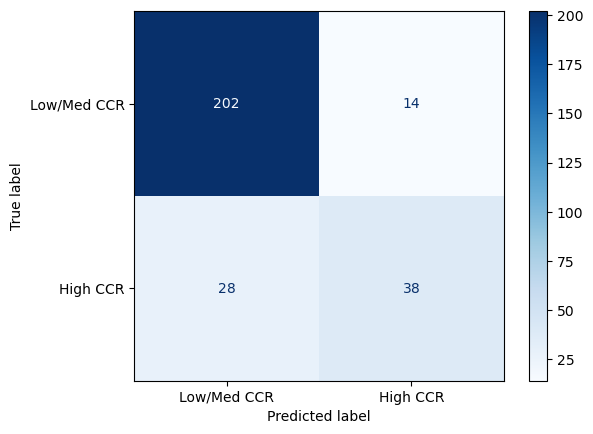

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low/Med CCR', 'High CCR'])
disp.plot(cmap='Blues')

### **Interpretation**

Here, our most important interpretation is seeing the value of predicted Low/Med CCR compared to the value of true Low/Med CCR schools. This confusion matrix tells us that it is detecting these schools well, only mislabeling 28 as a simple model.